In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

### Steger-Warming scheme

In [59]:
function stegerwarmingrk1!(t,uu)
    
    #u<=c
    urhoc = uutourhoc(uu,gamma)
    
    u = urhoc[1,:]
    rho = urhoc[2,:]
    c = urhoc[3,:]
    
    #initialization of uunew
    uunew =  deepcopy( zeros(size(uu)))
    
    #initialization of f
    fplus = deepcopy( zeros(size(uu)))
    fminus = deepcopy( zeros(size(uu)))
 
    
    #get fplus and fminus
    fplus[1,:] = (rho./(2gamma)).*(2gamma.*u+c-u)
    fplus[2,:] = (rho./(2gamma)).*(2(gamma-1).*u.^2+(u+c).^2)
    fplus[3,:] = (rho./(2gamma)).*((gamma-1).*u.^2+(((u+c).^3)/2)+((3-gamma).*(u+c).*c.^2)./(2(gamma-1)))
    
    fminus[1,:] = (rho./(2gamma)).*(u-c)
    fminus[2,:] = (rho./(2gamma)).*(u-c).^2
    fminus[3,:] = (rho./(2gamma)).*((((u-c).^3)/2)+((3-gamma).*(u-c).*c.^2)./(2(gamma-1)))
    
    for i in 2:1:length(uu[1,:])-1 # shrink a grid
        uunew[:,i] = (-(fplus[:,i]-fplus[:,i-1])/Δx)*Δt + (-(fminus[:,i+1]-fminus[:,i])/Δx)*Δt + uu[:,i]
    end
    
    # deal with the side
    uunew[:,length(uunew[1,:])] = uunew[:,length(uunew[1,:])-1]
    uunew[:,1] = uunew[:,2]
    
    t = t + Δt
    return t,uunew
end

stegerwarmingrk1! (generic function with 1 method)

In [33]:
function uutourhoc(uu::Any, gamma::Float64)
    
    tourhoc = Array{Float64,2}(UndefInitializer(),length(uu[:,1]),length(uu[1,:])) 
    
    tourhoc[1,:] = uu[2,:]./uu[1,:]
    tourhoc[2,:] = uu[1,:]
    
    pp = ((uu[3,:]-0.5tourhoc[2,:].*tourhoc[1,:].^2)*(gamma-1))
    
    tourhoc[3,:] = sqrt.(gamma.*abs.(pp)./(tourhoc[2,:]))
    
    return tourhoc

end

uutourhoc (generic function with 1 method)

In [34]:
function uutourhop(uu::Any, gamma::Float64)
    
    tourhop = Array{Float64,2}(UndefInitializer(),length(uu[:,1]),length(uu[1,:])) 
    
    tourhop[1,:] = uu[2,:]./uu[1,:]
    tourhop[2,:] = uu[1,:]
    
    tourhop[3,:] = ((uu[3,:]-0.5tourhop[2,:].*tourhop[1,:].^2)*(gamma-1))
    
    return tourhop

end

uutourhop (generic function with 1 method)

In [35]:
    nx = 201   
    gamma = 1.4
    xlim = (0,1.0)

    Lx = xlim[2]-xlim[1];
    Δx = Lx/(nx-1)

0.005

In [63]:
    # Initialization of ux and urhop    
    ux = xlim[1]:Δx:xlim[2]
    urhop = Array{Float64,2}(UndefInitializer(), 3,length(ux))
    
    for i in 1:1:nx
    if (ux[i] < 0.5) urhop[:,i] = [0,1,1]
    else urhop[:,i] = [0,0.125,0.1] end
    end  

    #From urhop make uu (u rho*u e)
    uu = Array{Float64,2}(UndefInitializer(), 3,length(ux))
    uu[1,:] = urhop[2,:];
    uu[2,:] = urhop[2,:].*urhop[1,:];
    uu[3,:] = urhop[3,:]/(gamma-1) + 0.5urhop[2,:].*urhop[1,:].^2;

    #get sound speed
    cc = uutourhoc(uu,gamma)[3,:]

    # Initial time and storage arrays
    t = 0.0
    thist = []
    uhist = []

    # CFL number and Δt
#    CFL = 0.5
#    Δt=abs(CFL*Δx/max(cc[:]))
    Δt = 0.001
    cfl = Δt*maximum(cc)/Δx

0.23664319132398465

In [56]:
    println("Δx=",Δx);
    println("Δt=",Δt);
    
    #Calculation time
    tf = 0.2
    tsample = Δt
    T = Δt:Δt:tf

Δx=0.005
Δt=0.001


0.001:0.001:0.2

In [91]:
    println("Δx=",Δx);
    println("Δt=",Δt);
    
    #Calculation time
    tf = 1
    tsample = Δt
    T = Δt:Δt:tf

    # Push it with time!
    for ti in T
#        t, uu = ausmrk3!(t,uu)
         t, uu = stegerwarmingrk1!(t,uu)
#        t, uu = movehoucha!(t,ux,uu,astar,Δx,Δt)
    
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(thist,deepcopy(t)) : nothing
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,deepcopy(uutourhop(uu,gamma))) : nothing
        #(isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,deepcopy(uu)) : nothing
    end
    

Δx=0.005
Δt=0.001


In [92]:
uSW = uhist;

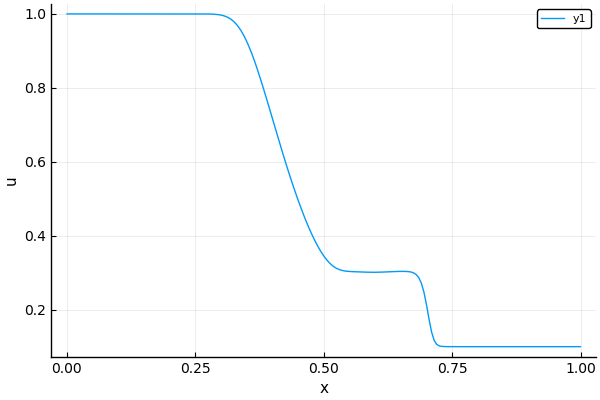

In [103]:
plt = plot(ylabel = "\$C_y\$", 
    xlabel = "Convective Time")
plot!(ux,uSW[300][3,:], legend = true, xlabel="x", ylabel="u", xtickfont=10, ytickfont=10)
#plot!(ux,uSW2[100][1,:], legend = true, xlabel="x", ylabel="u", xtickfont=10, ytickfont=10)
#plot!(ux,uAusm[200][2,:], legend = false, xlabel="x", ylabel="u", xtickfont=10, ytickfont=10)
plt

